In [28]:
# importanto bibliotecas
import pandas as pd
import numpy as np
import psycopg2
import dask.dataframe as dd
from collections import defaultdict

#pacotes gráficos
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, PageBreak, Spacer
from reportlab.lib import colors
from tabulate import tabulate

In [29]:
# importando bibliotecas conexão PDGT
import json
import argparse
import subprocess
import boto3
import time
from pyathena import connect
import pandas.io.sql as sqlio
import sys
from ydata_profiling import ProfileReport
from botocore import UNSIGNED
from botocore.config import Config
import boto3.session
from botocore import exceptions
from scipy.stats import chi2_contingency

In [30]:
class CustomException(Exception):
    pass

In [31]:
json_manifest_dbt = "target/manifest.json"
athena_bucket = "todos-athena-us-east-1"
athena_tmp_folder = f"s3://{athena_bucket}/"

In [32]:
def execute_athena_sql(query):
    client = boto3.client('athena', region_name='us-east-1')
    queryStart = client.start_query_execution(
    QueryString = query,
    ResultConfiguration = { 'OutputLocation': athena_tmp_folder})
    queryExecution = client.get_query_execution(QueryExecutionId=queryStart['QueryExecutionId'])
    while queryExecution['QueryExecution']['Status']['State'] in ('RUNNING', 'QUEUED'):
        time.sleep(5)
        queryExecution = client.get_query_execution(QueryExecutionId=queryStart['QueryExecutionId'])

In [33]:
def execute_athena_query(query):
    cursor = connect(s3_staging_dir=athena_tmp_folder,
                    region_name="us-east-1").cursor()
    cursor.execute(query)
    colls=','.join(str(f"{e[0]}") for e in cursor.description)
    results=pd.DataFrame(list(cursor), columns=colls.split(","))
    return results

In [34]:
# definindo query
query_profissionais = """
-- BASE PROFISSIONAIS
WITH permanencia AS (
    SELECT
        ag.id_profissional,
        MAX(ag.dt_agendamento) mx_atendimento
    FROM pdgt_amorsaude_operacoes.fl_agendamentos ag
    WHERE ag.id_status IN (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3)
    GROUP BY ag.id_profissional
),
atendimento AS (
    SELECT
        id_profissional,
        AVG(atendimentos_mes) media_atd_mes
    FROM (
        SELECT
            ag.id_profissional,
            DATE_TRUNC('MONTH', ag.dt_agendamento) mes,
            COUNT(*) atendimentos_mes
        FROM pdgt_amorsaude_operacoes.fl_agendamentos ag
        WHERE ag.id_status IN (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3)
        GROUP BY
            ag.id_profissional,
            DATE_TRUNC('MONTH', ag.dt_agendamento)
    ) subquery
    GROUP BY id_profissional
),
infos_profissionais AS (
    SELECT
        spu.profissional_id AS id_profissional,
        COUNT(DISTINCT spu.unidade_id) AS qtd_unidades,
        CASE WHEN COUNT(spu.unidade_id) > 1 THEN 1 ELSE 0 END multiplas_unidades,
        spe.qtd_especialidades,
        spe.multiplas_especialidades
    FROM todos_data_lake_trusted_feegow.profissionais_unidades spu
    LEFT JOIN (
        SELECT
            spe.profissional_id AS id_profissional,
            COUNT(DISTINCT spe.especialidade_id) AS qtd_especialidades,
            CASE WHEN COUNT(spe.especialidade_id) > 1 THEN 1 ELSE 0 END multiplas_especialidades
        FROM todos_data_lake_trusted_feegow.profissional_especialidades spe
        GROUP BY spe.profissional_id
    ) spe ON spu.profissional_id = spe.id_profissional
    GROUP BY spu.profissional_id, spe.qtd_especialidades, spe.multiplas_especialidades
)
SELECT
    sp.id AS id_profissional,
    sp.nome_profissional,
    DATE_DIFF('YEAR', sp.nascimento, current_date) AS idade,
    CASE WHEN DATE_DIFF('YEAR', sp.nascimento, current_date) < 18
        OR DATE_DIFF('YEAR', sp.nascimento, current_date) > 90 THEN 1
        ELSE 0 END idade_errada,
    DATE_DIFF('YEAR', sp.sys_date, per.mx_atendimento) AS anos_empresa,
    DATE_DIFF('MONTH', sp.sys_date, per.mx_atendimento) AS meses_empresa,
    ss.nomesexo AS sexo,
    ip.qtd_unidades,
    ip.multiplas_unidades,
    ip.qtd_especialidades,
    ip.multiplas_especialidades,
    atd.media_atd_mes,
    CASE WHEN sp.sys_active = 1 AND sp.ativo = 'on' THEN 'Ativo' ELSE 'Inativo' END cadastro,
    1 AS qtd_profissionais
FROM todos_data_lake_trusted_feegow.profissionais sp
LEFT JOIN todos_data_lake_trusted_feegow.sexo ss ON sp.sexo_id = ss.id
LEFT JOIN infos_profissionais ip ON sp.id = ip.id_profissional
JOIN permanencia per ON per.id_profissional = sp.id
LEFT JOIN atendimento atd ON atd.id_profissional = sp.id
WHERE UPPER(sp.nome_profissional) NOT LIKE '%FEEGOW%'
  AND sp.id <> 502888
  AND atd.media_atd_mes IS NOT NULL;
"""

In [35]:
# setando o df
df = execute_athena_query(query_profissionais)
df

,id_profissional,nome_profissional,idade,idade_errada,anos_empresa,meses_empresa,sexo,qtd_unidades,multiplas_unidades,qtd_especialidades,multiplas_especialidades,media_atd_mes,cadastro,qtd_profissionais
0,135568,Anair De Souza,65.0,0,5.0,60.0,Feminino,5.0,1.0,1.0,0.0,85.650000,Ativo,1
1,237046,Jéssica Arruda Leme,31.0,0,3.0,40.0,Feminino,1.0,0.0,1.0,0.0,12.153846,Inativo,1
2,243601,MICHELLE PEREIRA RIBEIRO,NaN,0,0.0,4.0,None,1.0,0.0,1.0,0.0,2.500000,Inativo,1
3,480094,Fabricio Bride Soares,NaN,0,2.0,32.0,None,2.0,1.0,1.0,0.0,57.156250,Ativo,1
4,494319,Adriana Maria De Souza,NaN,0,1.0,12.0,None,NaN,NaN,NaN,NaN,32.214286,Inativo,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24134,503252,Pedro Alcides Felipes,32.0,0,0.0,9.0,Masculino,1.0,0.0,1.0,0.0,37.800000,Inativo,1
24135,503560,Karla Daniane Teles Batista Cantuária,42.0,0,0.0,0.0,None,1.0,0.0,1.0,0.0,9.000000,Inativo,1
24136,506847,Suellen Del Pilar Travassos Sanchez Rojas,31.0,0,0.0,0.0,None,2.0,1.0,1.0,0.0,15.000000,Inativo,1
24137,507345,Rodolfo Grillo Menegon,30.0,0,0.0,0.0,Masculino,1.0,0.0,1.0,0.0,156.000000,Inativo,1


In [36]:
df.to_excel('base_profissionais.xlsx', index=False)

In [37]:
# contagem de quantas entradas temos na base de profissionais
qtd_cadastros = len(df['id_profissional'])
qtd_cadastros

24139

In [38]:
# evidenciando a quantidade de nulidades nos cadastros médicos
null_counts = df.isnull().sum()
null_percentages = (df.isnull().mean()*100).round(2)
null_df = pd.DataFrame({
    'Contagem de Nulos': null_counts,
    'Porcentagem de Nulos': null_percentages
})
print(null_df)

                          Contagem de Nulos  Porcentagem de Nulos
id_profissional                           0                  0.00
nome_profissional                         0                  0.00
idade                                  2897                 12.00
idade_errada                              0                  0.00
anos_empresa                              4                  0.02
meses_empresa                             4                  0.02
sexo                                   2771                 11.48
qtd_unidades                           1027                  4.25
multiplas_unidades                     1027                  4.25
qtd_especialidades                     1320                  5.47
multiplas_especialidades               1320                  5.47
media_atd_mes                             0                  0.00
cadastro                                  0                  0.00
qtd_profissionais                         0                  0.00


In [39]:
# evidenciando a quantidade de entradas com idade errada
qtd_idades_erradas = df['idade_errada'].sum()

pct_idades_erradas = (qtd_idades_erradas / qtd_cadastros)*100
print(f'Cadastros com data de nascimento errada: {qtd_idades_erradas}')
print(f'Porcentagem de cadastros com data de nascimento errada: {pct_idades_erradas:.2f}%') 


Cadastros com data de nascimento errada: 115
Porcentagem de cadastros com data de nascimento errada: 0.48%


In [40]:
# demonstrando quantidade de ativos e inativos
active_users = df['cadastro'].value_counts()['Ativo']
inactive_users = df['cadastro'].value_counts()['Inativo']

pct_active_users = active_users / qtd_cadastros * 100
pct_inactive_users = inactive_users / qtd_cadastros * 100

print(f'Profissionais ativos: {active_users}')
print(f'Porcentagem profissionais ativos: {pct_active_users:.2f}%')
print(f'Profissionais inativos: {inactive_users}')
print(f'Porcentagem profissionais inativos: {pct_inactive_users:.2f}%')

Profissionais ativos: 13722
Porcentagem profissionais ativos: 56.85%
Profissionais inativos: 10417
Porcentagem profissionais inativos: 43.15%


In [41]:
#tratando a base de profissionais
df = df.dropna()
df_ativos = df[df['cadastro'] != 'Inativo']
df_ativos = df_ativos[(df_ativos['idade'] >= 18) & (df_ativos['idade'] <= 90)]

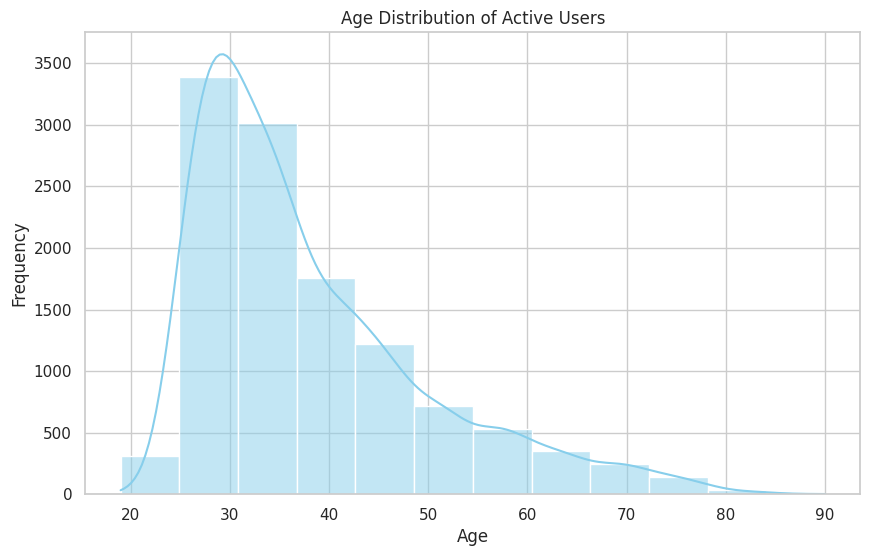

In [42]:
# Set the style for Seaborn
sns.set(style='whitegrid')

# Create the histogram using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.histplot(data=df_ativos, x='idade', bins=12, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Active Users')

# Show the plot
plt.show()

In [43]:
#criando colunas de daixa etária
age_bins = [18, 25, 35, 45, 55, 65, float('inf')]

age_labels = ['A: 18-25', 'B: 26-35', 'C: 36-45', 'D: 46-55', 'E: 56-65', 'F: 65+']

df_ativos['faixa_etaria'] = pd.cut(df_ativos['idade'], bins=age_bins, labels=age_labels, right=True)

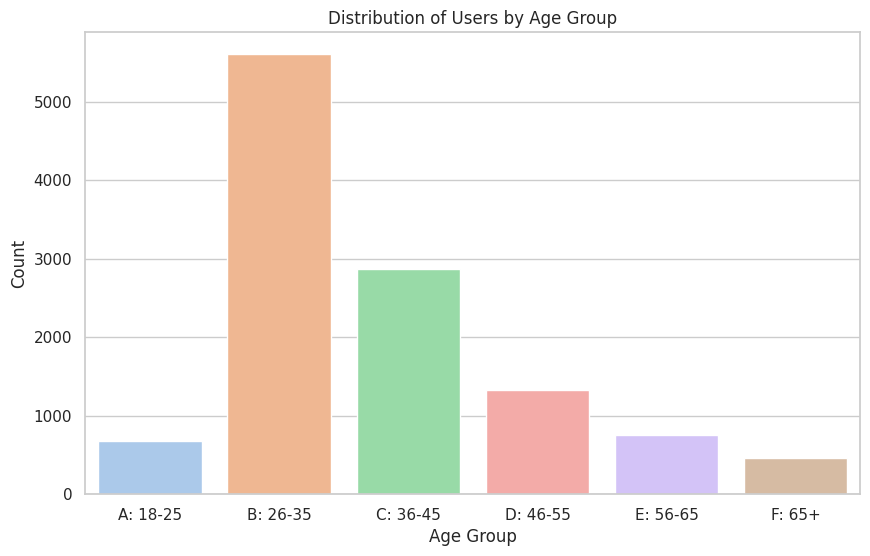

In [44]:

# Set the style for Seaborn
sns.set(style='whitegrid')

# Create the bar chart using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(data=df_ativos, x='faixa_etaria', palette='pastel')

# Add labels and title
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Distribution of Users by Age Group')

# Show the plot
plt.show()

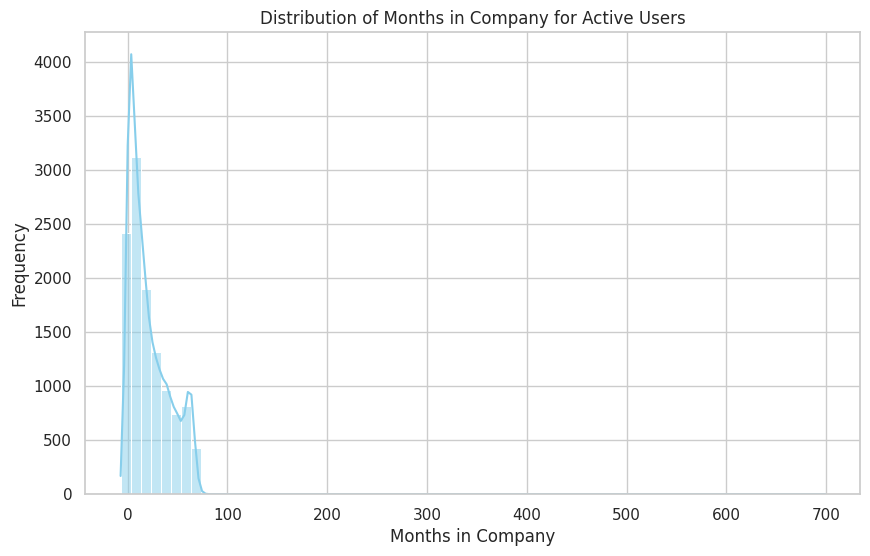

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for Seaborn
sns.set(style='whitegrid')

# Create the histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ativos, x='meses_empresa', bins=70, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Months in Company')
plt.ylabel('Frequency')
plt.title('Distribution of Months in Company for Active Users')

# Show the plot
plt.show()

In [46]:
df_ativos.to_excel('validacao_df_ativos.xlsx', index=False)

In [47]:
#criando colunas de daixa etária
age_bins = [0, 7, 12, 46, 56, 66, float('inf')]

age_labels = ['A: 18-25', 'C: 26-35', 'D: 36-45', 'E: 46-55', 'F: 56-65', 'G: 65+']

df_ativos['faixa_etaria'] = pd.cut(df_ativos['idade'], bins=age_bins, labels=age_labels, right=True)

In [48]:
# definindo query profissional especialidade

query_especialidade = """
-- BASE ESPECIALIDADES
WITH permanencia AS (
    SELECT
        ag.id_profissional,
        MAX(ag.dt_agendamento) mx_atendimento
    FROM pdgt_amorsaude_operacoes.fl_agendamentos ag
    WHERE ag.id_status IN (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3)
    GROUP BY ag.id_profissional
),
atendimento AS (
    SELECT
        id_profissional,
        id_especialidade,
        AVG(atendimentos_mes) media_atd_mes
    FROM (
        SELECT
            ag.id_profissional,
            ag.id_especialidade,
            DATE_TRUNC('MONTH', ag.dt_agendamento) mes,
            COUNT(*) atendimentos_mes
        FROM pdgt_amorsaude_operacoes.fl_agendamentos ag
        WHERE ag.id_status IN (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3)
        GROUP BY
            ag.id_profissional,
            ag.id_especialidade,
            DATE_TRUNC('MONTH', ag.dt_agendamento)
    ) subquery
    GROUP BY id_profissional, id_especialidade
),
infos_profissionais AS (
    SELECT
        spu.profissional_id AS id_profissional,
        COUNT(DISTINCT spu.unidade_id) AS qtd_unidades,
        CASE WHEN COUNT(spu.unidade_id) > 1 THEN 1 ELSE 0 END multiplas_unidades,
        spe.qtd_especialidades,
        spe.multiplas_especialidades
    FROM todos_data_lake_trusted_feegow.profissionais_unidades spu
    LEFT JOIN (
        SELECT
            spe.profissional_id AS id_profissional,
            COUNT(DISTINCT spe.especialidade_id) AS qtd_especialidades,
            CASE WHEN COUNT(spe.especialidade_id) > 1 THEN 1 ELSE 0 END multiplas_especialidades
        FROM todos_data_lake_trusted_feegow.profissional_especialidades spe
        GROUP BY spe.profissional_id
    ) spe ON spu.profissional_id = spe.id_profissional
    GROUP BY spu.profissional_id, spe.qtd_especialidades, spe.multiplas_especialidades
)
SELECT DISTINCT
    sp.id AS id_profissional,
    spe.especialidade_id,
    se.nome_especialidade,
    DATE_DIFF('YEAR', sp.nascimento, current_date) AS idade,
    DATE_DIFF('YEAR', sp.sys_date, per.mx_atendimento) AS anos_empresa,
    DATE_DIFF('MONTH', sp.sys_date, per.mx_atendimento) AS meses_empresa,
    ss.nomesexo AS sexo,
    CASE WHEN ss.nomesexo = 'Masculino' THEN 1 ELSE 0 END profissional_masculino,
    CASE WHEN ss.nomesexo = 'Feminino' THEN 1 ELSE 0 END profissional_feminino,
    atd.media_atd_mes,
    ip.qtd_unidades,
    ip.multiplas_unidades,
    ip.qtd_especialidades,
    ip.multiplas_especialidades,
    1 AS qtd_medicos
FROM todos_data_lake_trusted_feegow.profissionais sp
LEFT JOIN todos_data_lake_trusted_feegow.profissional_especialidades spe ON spe.profissional_id = sp.id
LEFT JOIN todos_data_lake_trusted_feegow.especialidades se ON spe.especialidade_id = se.id
LEFT JOIN todos_data_lake_trusted_feegow.sexo ss ON sp.sexo_id = ss.id
LEFT JOIN infos_profissionais ip ON sp.id = ip.id_profissional
JOIN permanencia per ON per.id_profissional = sp.id
LEFT JOIN atendimento atd ON atd.id_profissional = sp.id AND atd.id_especialidade = spe.especialidade_id
WHERE UPPER(sp.nome_profissional) NOT LIKE '%FEEGOW%'
  AND sp.id <> 502888
  AND sp.sys_active = 1
  AND sp.ativo = 'on'
  AND atd.media_atd_mes IS NOT NULL;"""

In [49]:
# setando o df especialidade
df_especialidade_profissional = execute_athena_query(query_especialidade)
df_especialidade_profissional

,id_profissional,especialidade_id,nome_especialidade,idade,anos_empresa,meses_empresa,sexo,profissional_masculino,profissional_feminino,media_atd_mes,qtd_unidades,multiplas_unidades,qtd_especialidades,multiplas_especialidades,qtd_medicos
0,241991,98,Dermatologia,74.0,4.0,56.0,Feminino,0,1,98.352941,1.0,0.0,1.0,0.0,1
1,485057,98,Dermatologia,36.0,2.0,32.0,Feminino,0,1,104.187500,1.0,0.0,1.0,0.0,1
2,504879,188,Psicologia,28.0,0.0,9.0,Feminino,0,1,43.000000,1.0,0.0,1.0,0.0,1
3,500927,121,Neurologia,28.0,1.0,18.0,Feminino,0,1,66.200000,1.0,0.0,1.0,0.0,1
4,231071,129,Ortopedia e Traumatologia,67.0,5.0,62.0,Masculino,1,0,105.025641,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14892,507044,104,Endocrinologia,46.0,0.0,7.0,Feminino,0,1,65.000000,1.0,0.0,1.0,0.0,1
14893,507383,141,Psiquiatria,41.0,0.0,6.0,Feminino,0,1,48.857143,1.0,0.0,1.0,0.0,1
14894,506775,188,Psicologia,51.0,0.0,4.0,Feminino,0,1,9.500000,1.0,0.0,1.0,0.0,1
14895,510847,96,Cardiologia,28.0,0.0,3.0,Masculino,1,0,38.750000,1.0,0.0,2.0,1.0,1


In [50]:
df_especialidade_profissional.columns

Index(['id_profissional', 'especialidade_id', 'nome_especialidade', 'idade',
       'anos_empresa', 'meses_empresa', 'sexo', 'profissional_masculino',
       'profissional_feminino', 'media_atd_mes', 'qtd_unidades',
       'multiplas_unidades', 'qtd_especialidades', 'multiplas_especialidades',
       'qtd_medicos'],
      dtype='object')

In [51]:
# criando df agrupado por especialidade
df_especialidade = df_especialidade_profissional.groupby(['especialidade_id', 'nome_especialidade']).agg({
            'idade': 'median',
            'anos_empresa': 'median',
            'meses_empresa': 'median',
            'profissional_masculino': 'sum',
            'profissional_feminino': 'sum',
            'media_atd_mes': 'median',
            'qtd_especialidades': 'median',
            'qtd_unidades': 'median',
            'multiplas_unidades': 'sum',
            'multiplas_especialidades': 'sum',
            'qtd_medicos': 'sum'
       }).reset_index()

df_especialidade['pct_homens'] = df_especialidade['profissional_masculino'] / df_especialidade['qtd_medicos']
df_especialidade['pct_mulheres'] = df_especialidade['profissional_feminino'] / df_especialidade['qtd_medicos']
df_especialidade['pct_especialidade'] = df_especialidade['qtd_medicos'] / sum(df_especialidade['qtd_medicos'])
df_especialidade['pct_multiplas_unidades'] = df_especialidade['multiplas_unidades'] / df_especialidade['qtd_medicos']
df_especialidade['pct_multiplas_especialidades'] = df_especialidade['multiplas_especialidades'] / df_especialidade['qtd_medicos']

df_especialidade

,especialidade_id,nome_especialidade,idade,anos_empresa,meses_empresa,profissional_masculino,profissional_feminino,media_atd_mes,qtd_especialidades,qtd_unidades,multiplas_unidades,multiplas_especialidades,qtd_medicos,pct_homens,pct_mulheres,pct_especialidade,pct_multiplas_unidades,pct_multiplas_especialidades
0,89,Clinica Médica,31.0,0.0,9.0,1094,1285,76.824009,1.0,1.0,987.0,776.0,2558,0.427678,0.502346,0.171712,0.385848,0.303362
1,90,Cirurgia Geral,36.0,1.0,17.0,89,28,23.109649,2.0,1.0,62.0,82.0,130,0.684615,0.215385,0.008727,0.476923,0.630769
2,96,Cardiologia,44.0,2.0,25.0,395,141,115.346667,1.0,2.0,294.0,130.0,572,0.690559,0.246503,0.038397,0.513986,0.227273
3,98,Dermatologia,35.0,1.0,18.0,135,481,76.034483,1.0,1.0,318.0,106.0,678,0.199115,0.709440,0.045513,0.469027,0.156342
4,101,Medicina do Trabalho,54.0,3.0,45.0,9,5,14.461538,2.0,3.0,11.0,14.0,15,0.600000,0.333333,0.001007,0.733333,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,328,Endoscopia,36.0,4.0,57.0,1,0,1.000000,1.0,17.0,1.0,0.0,1,1.000000,0.000000,0.000067,1.000000,0.000000
63,329,Genética médica,27.0,0.0,7.0,0,1,53.777778,1.0,1.0,0.0,0.0,1,0.000000,1.000000,0.000067,0.000000,0.000000
64,333,Medicina intensiva,39.0,0.0,3.0,0,1,9.250000,1.0,1.0,0.0,0.0,1,0.000000,1.000000,0.000067,0.000000,0.000000
65,336,Patologia,29.0,0.0,5.0,0,1,10.000000,1.0,1.0,0.0,0.0,1,0.000000,1.000000,0.000067,0.000000,0.000000


In [52]:
# descrevendo os dados
df_especialidade.describe().T

,count,mean,std,min,25%,50%,75%,max
especialidade_id,67.0,192.731343,83.740324,89.000000,122.000000,152.000000,277.000000,337.000000
idade,67.0,39.313433,7.757614,24.000000,34.000000,38.000000,43.500000,61.000000
anos_empresa,67.0,1.276119,1.184763,0.000000,0.250000,1.000000,2.000000,5.000000
meses_empresa,67.0,20.440299,14.095057,1.000000,10.000000,17.000000,27.500000,61.000000
profissional_masculino,67.0,84.358209,171.692352,0.000000,1.000000,12.000000,93.000000,1094.000000
profissional_feminino,67.0,119.462687,262.438814,0.000000,1.000000,9.000000,75.000000,1356.000000
media_atd_mes,67.0,37.040121,31.868497,1.000000,11.275000,27.900000,59.899148,126.283217
qtd_especialidades,67.0,1.320896,0.562068,1.000000,1.000000,1.000000,2.000000,3.500000
qtd_unidades,67.0,1.664179,1.991246,1.000000,1.000000,1.000000,2.000000,17.000000
multiplas_unidades,67.0,88.641791,163.662041,0.000000,1.000000,11.000000,100.000000,987.000000


In [53]:
query_unidade = """
-- BASE UNIDADES
WITH permanencia AS (
    SELECT
        ag.id_profissional,
        MAX(ag.dt_agendamento) mx_atendimento
    FROM pdgt_amorsaude_operacoes.fl_agendamentos ag
    WHERE ag.id_status IN (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3)
    GROUP BY ag.id_profissional
),
atendimento AS (
    SELECT
        id_profissional,
        id_unidade,
        AVG(atendimentos_mes) media_atd_mes
    FROM (
        SELECT
            ag.id_profissional,
            ag.id_unidade,
            DATE_TRUNC('MONTH', ag.dt_agendamento) mes,
            COUNT(*) atendimentos_mes
        FROM pdgt_amorsaude_operacoes.fl_agendamentos ag
        WHERE ag.id_status IN (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3)
        GROUP BY
            ag.id_profissional,
            ag.id_unidade,
            DATE_TRUNC('MONTH', ag.dt_agendamento)
    ) subquery
    GROUP BY id_profissional, id_unidade
),
infos_profissionais AS (
    SELECT
        spu.profissional_id AS id_profissional,
        COUNT(DISTINCT spu.unidade_id) AS qtd_unidades,
        CASE WHEN COUNT(spu.unidade_id) > 1 THEN 1 ELSE 0 END multiplas_unidades,
        spe.qtd_especialidades,
        spe.multiplas_especialidades
    FROM todos_data_lake_trusted_feegow.profissionais_unidades spu
    LEFT JOIN (
        SELECT
            spe.profissional_id AS id_profissional,
            COUNT(DISTINCT spe.especialidade_id) AS qtd_especialidades,
            CASE WHEN COUNT(spe.especialidade_id) > 1 THEN 1 ELSE 0 END multiplas_especialidades
        FROM todos_data_lake_trusted_feegow.profissional_especialidades spe
        GROUP BY spe.profissional_id
    ) spe ON spu.profissional_id = spe.id_profissional
    GROUP BY spu.profissional_id, spe.qtd_especialidades, spe.multiplas_especialidades
)
SELECT DISTINCT
    sp.id AS id_profissional,
    spu.unidade_id,
    su.nome_fantasia nome_unidade,
    DATE_DIFF('YEAR', sp.nascimento, current_date) AS idade,
    DATE_DIFF('YEAR', sp.sys_date, per.mx_atendimento) AS anos_empresa,
    DATE_DIFF('MONTH', sp.sys_date, per.mx_atendimento) AS meses_empresa,
    ss.nomesexo AS sexo,
    CASE WHEN ss.nomesexo = 'Masculino' THEN 1 ELSE 0 END profissional_masculino,
    CASE WHEN ss.nomesexo = 'Feminino' THEN 1 ELSE 0 END profissional_feminino,
    atd.media_atd_mes,
    ip.qtd_unidades,
    ip.multiplas_unidades,
    ip.qtd_especialidades,
    ip.multiplas_especialidades,
    1 AS qtd_medicos
FROM todos_data_lake_trusted_feegow.profissionais sp
LEFT JOIN todos_data_lake_trusted_feegow.profissionais_unidades spu ON spu.profissional_id = sp.id
LEFT JOIN todos_data_lake_trusted_feegow.unidades su ON su.id = spu.unidade_id
LEFT JOIN todos_data_lake_trusted_feegow.sexo ss ON sp.sexo_id = ss.id
LEFT JOIN infos_profissionais ip ON sp.id = ip.id_profissional
JOIN permanencia per ON per.id_profissional = sp.id
LEFT JOIN atendimento atd ON atd.id_profissional = sp.id AND atd.id_unidade = spu.unidade_id
WHERE UPPER(sp.nome_profissional) NOT LIKE '%FEEGOW%'
  AND sp.id <> 502888
  AND sp.sys_active = 1
  AND sp.ativo = 'on'
  AND atd.media_atd_mes IS NOT NULL;"""

In [54]:
# setando o df unidade
df_unidade_profissional = execute_athena_query(query_unidade)
df_unidade_profissional

,id_profissional,unidade_id,nome_unidade,idade,anos_empresa,meses_empresa,sexo,profissional_masculino,profissional_feminino,media_atd_mes,qtd_unidades,multiplas_unidades,qtd_especialidades,multiplas_especialidades,qtd_medicos
0,506532,19850,AmorSaúde Erechim,44.0,0.0,9.0,Masculino,1,0,42.500000,1,0,1.0,0.0,1
1,505383,19417,AmorSaúde São Roque,39.0,0.0,9.0,None,0,0,74.400000,1,0,1.0,0.0,1
2,486042,19729,AmorSaúde Teixeira de Freitas,27.0,3.0,36.0,Feminino,0,1,24.529412,1,0,1.0,0.0,1
3,500664,19947,AmorSaúde Guarujá,40.0,1.0,18.0,Feminino,0,1,51.000000,2,1,1.0,0.0,1
4,501133,19566,AmorSaúde Araçatuba,31.0,1.0,13.0,Feminino,0,1,26.833333,4,1,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23232,230401,19346,AmorSaúde Teresópolis,70.0,5.0,64.0,Feminino,0,1,58.285714,1,0,1.0,0.0,1
23233,493052,19654,AmorSaúde SP Tucuruvi,31.0,2.0,28.0,Feminino,0,1,39.000000,8,1,1.0,0.0,1
23234,493052,19404,AmorSaúde SP Pirituba,31.0,2.0,28.0,Feminino,0,1,65.000000,8,1,1.0,0.0,1
23235,505734,19420,AmorSaúde Varginha,29.0,0.0,11.0,Masculino,1,0,254.500000,6,1,1.0,0.0,1


In [55]:
# criando df agrupado por unidade
df_unidade = df_unidade_profissional.groupby(['unidade_id', 'nome_unidade']).agg({
            'idade': 'median',
            'anos_empresa': 'median',
            'meses_empresa': 'median',
            'profissional_masculino': 'sum',
            'profissional_feminino': 'sum',
            'media_atd_mes': 'median',
            'qtd_especialidades': 'median',
            'qtd_unidades': 'median',
            'multiplas_unidades': 'sum',
            'multiplas_especialidades': 'sum',
            'qtd_medicos': 'sum'
       }).reset_index()

df_unidade['pct_homens'] = df_unidade['profissional_masculino'] / df_unidade['qtd_medicos']
df_unidade['pct_mulheres'] = df_unidade['profissional_feminino'] / df_unidade['qtd_medicos']
df_unidade['pct_unidade'] = df_unidade['qtd_medicos'] / sum(df_unidade['qtd_medicos'])
df_unidade['pct_multiplas_unidades'] = df_unidade['multiplas_unidades'] / df_unidade['qtd_medicos']
df_unidade['pct_multiplas_especialidades'] = df_unidade['multiplas_especialidades'] / df_unidade['qtd_medicos']

df_unidade

,unidade_id,nome_unidade,idade,anos_empresa,meses_empresa,profissional_masculino,profissional_feminino,media_atd_mes,qtd_especialidades,qtd_unidades,multiplas_unidades,multiplas_especialidades,qtd_medicos,pct_homens,pct_mulheres,pct_unidade,pct_multiplas_unidades,pct_multiplas_especialidades
0,18263,AmorSaúde Carapicuíba,38.0,1.5,23.5,16,11,86.500000,1.0,3.0,24,7.0,30,0.533333,0.366667,0.001291,0.800000,0.233333
1,19270,AmorSaúde Salvador Centro,37.0,2.0,26.0,35,57,60.428571,1.0,2.0,79,10.0,103,0.339806,0.553398,0.004433,0.766990,0.097087
2,19272,AmorSaúde SP Itaquera,48.5,4.0,54.0,25,13,102.347826,1.0,5.0,34,6.0,39,0.641026,0.333333,0.001678,0.871795,0.153846
3,19275,AmorSaúde Vitória da Conquista,39.0,2.0,27.0,25,37,95.250000,1.0,1.0,33,11.0,69,0.362319,0.536232,0.002969,0.478261,0.159420
4,19276,AmorSaúde Curitiba Pinheirinho,31.0,1.0,20.0,23,24,53.450000,1.0,3.0,39,8.0,48,0.479167,0.500000,0.002066,0.812500,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,19990,AmorSaúde Piracicaba Vila Sônia,41.0,1.0,18.0,11,12,21.000000,1.0,2.0,22,4.0,23,0.478261,0.521739,0.000990,0.956522,0.173913
429,19991,AmorSaúde Viçosa,26.5,0.0,1.0,6,2,16.000000,1.0,1.0,2,1.0,8,0.750000,0.250000,0.000344,0.250000,0.125000
430,19992,AmorSaúde Ananindeua Centro,44.0,1.5,18.5,3,1,13.500000,2.0,3.0,4,3.0,4,0.750000,0.250000,0.000172,1.000000,0.750000
431,19993,AmorSaúde Igarassu,37.0,1.0,16.0,7,7,9.750000,1.0,2.5,12,2.0,14,0.500000,0.500000,0.000602,0.857143,0.142857


In [56]:
df_unidade

,unidade_id,nome_unidade,idade,anos_empresa,meses_empresa,profissional_masculino,profissional_feminino,media_atd_mes,qtd_especialidades,qtd_unidades,multiplas_unidades,multiplas_especialidades,qtd_medicos,pct_homens,pct_mulheres,pct_unidade,pct_multiplas_unidades,pct_multiplas_especialidades
0,18263,AmorSaúde Carapicuíba,38.0,1.5,23.5,16,11,86.500000,1.0,3.0,24,7.0,30,0.533333,0.366667,0.001291,0.800000,0.233333
1,19270,AmorSaúde Salvador Centro,37.0,2.0,26.0,35,57,60.428571,1.0,2.0,79,10.0,103,0.339806,0.553398,0.004433,0.766990,0.097087
2,19272,AmorSaúde SP Itaquera,48.5,4.0,54.0,25,13,102.347826,1.0,5.0,34,6.0,39,0.641026,0.333333,0.001678,0.871795,0.153846
3,19275,AmorSaúde Vitória da Conquista,39.0,2.0,27.0,25,37,95.250000,1.0,1.0,33,11.0,69,0.362319,0.536232,0.002969,0.478261,0.159420
4,19276,AmorSaúde Curitiba Pinheirinho,31.0,1.0,20.0,23,24,53.450000,1.0,3.0,39,8.0,48,0.479167,0.500000,0.002066,0.812500,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,19990,AmorSaúde Piracicaba Vila Sônia,41.0,1.0,18.0,11,12,21.000000,1.0,2.0,22,4.0,23,0.478261,0.521739,0.000990,0.956522,0.173913
429,19991,AmorSaúde Viçosa,26.5,0.0,1.0,6,2,16.000000,1.0,1.0,2,1.0,8,0.750000,0.250000,0.000344,0.250000,0.125000
430,19992,AmorSaúde Ananindeua Centro,44.0,1.5,18.5,3,1,13.500000,2.0,3.0,4,3.0,4,0.750000,0.250000,0.000172,1.000000,0.750000
431,19993,AmorSaúde Igarassu,37.0,1.0,16.0,7,7,9.750000,1.0,2.5,12,2.0,14,0.500000,0.500000,0.000602,0.857143,0.142857


In [57]:
# definindo query profissional especialidade região clinica
query_regional = """
-- REGIONAL
WITH permanencia AS (
    SELECT
        ag.id_profissional,
        MAX(ag.dt_agendamento) mx_atendimento
    FROM pdgt_amorsaude_operacoes.fl_agendamentos ag
    WHERE ag.id_status IN (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3)
    GROUP BY ag.id_profissional
),
atendimento AS (
    SELECT
        id_profissional,
        id_regional,
        AVG(atendimentos_mes) media_atd_mes
    FROM (
        SELECT
            ag.id_profissional,
            ag.id_regional,
            DATE_TRUNC('MONTH', ag.dt_agendamento) mes,
            COUNT(*) atendimentos_mes
        FROM pdgt_amorsaude_operacoes.fl_agendamentos ag
        WHERE ag.id_status IN (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3)
        GROUP BY
            ag.id_profissional,
            ag.id_regional,
            DATE_TRUNC('MONTH', ag.dt_agendamento)
    ) subquery
    GROUP BY id_profissional, id_regional
),
infos_profissionais AS (
    SELECT
        spu.profissional_id AS id_profissional,
        COUNT(DISTINCT spu.unidade_id) AS qtd_unidades,
        CASE WHEN COUNT(spu.unidade_id) > 1 THEN 1 ELSE 0 END multiplas_unidades,
        spe.qtd_especialidades,
        spe.multiplas_especialidades
    FROM todos_data_lake_trusted_feegow.profissionais_unidades spu
    LEFT JOIN (
        SELECT
            spe.profissional_id AS id_profissional,
            COUNT(DISTINCT spe.especialidade_id) AS qtd_especialidades,
            CASE WHEN COUNT(spe.especialidade_id) > 1 THEN 1 ELSE 0 END multiplas_especialidades
        FROM todos_data_lake_trusted_feegow.profissional_especialidades spe
        GROUP BY spe.profissional_id
    ) spe ON spu.profissional_id = spe.id_profissional
    GROUP BY spu.profissional_id, spe.qtd_especialidades, spe.multiplas_especialidades
)
SELECT DISTINCT
    sp.id AS id_profissional,
    sur.descricao regional,
    DATE_DIFF('YEAR', sp.nascimento, current_date) AS idade,
    DATE_DIFF('YEAR', sp.sys_date, per.mx_atendimento) AS anos_empresa,
    DATE_DIFF('MONTH', sp.sys_date, per.mx_atendimento) AS meses_empresa,
    ss.nomesexo AS sexo,
    CASE WHEN ss.nomesexo = 'Masculino' THEN 1 ELSE 0 END profissional_masculino,
    CASE WHEN ss.nomesexo = 'Feminino' THEN 1 ELSE 0 END profissional_feminino,
    atd.media_atd_mes,
    ip.qtd_unidades,
    ip.multiplas_unidades,
    ip.qtd_especialidades,
    ip.multiplas_especialidades,
    1 AS qtd_medicos
FROM todos_data_lake_trusted_feegow.profissionais sp
LEFT JOIN todos_data_lake_trusted_feegow.profissionais_unidades spu ON spu.profissional_id = sp.id
LEFT JOIN todos_data_lake_trusted_feegow.unidades su ON su.id = spu.unidade_id
LEFT JOIN todos_data_lake_trusted_feegow.unidades_regioes sur ON sur.id = su.regiao_id
LEFT JOIN todos_data_lake_trusted_feegow.sexo ss ON sp.sexo_id = ss.id
LEFT JOIN infos_profissionais ip ON sp.id = ip.id_profissional
JOIN permanencia per ON per.id_profissional = sp.id
LEFT JOIN atendimento atd ON atd.id_profissional = sp.id AND atd.id_regional = su.regiao_id
WHERE UPPER(sp.nome_profissional) NOT LIKE '%FEEGOW%'
  AND sp.id <> 502888
  AND sp.sys_active = 1
  AND sp.ativo = 'on'
  AND atd.media_atd_mes IS NOT NULL;"""

In [58]:
# setando o df_regional_profissional
#df_regional_profissional = pd.read_sql_query(query_regional,con=connection)
df_regional_profissional = execute_athena_query(query_regional)
df_regional_profissional

,id_profissional,regional,idade,anos_empresa,meses_empresa,sexo,profissional_masculino,profissional_feminino,media_atd_mes,qtd_unidades,multiplas_unidades,qtd_especialidades,multiplas_especialidades,qtd_medicos
0,232401,Sul,56.0,5.0,63.0,Masculino,1,0,431.393939,4,1,1.0,0.0,1
1,506658,NE1,24.0,0.0,0.0,Feminino,0,1,1.000000,1,0,1.0,0.0,1
2,242539,RJ,59.0,4.0,56.0,Masculino,1,0,57.250000,7,1,1.0,1.0,1
3,503970,NE2,31.0,0.0,9.0,Feminino,0,1,28.600000,1,0,1.0,0.0,1
4,504420,SP CAV,65.0,1.0,13.0,None,0,0,88.600000,2,1,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,501603,NE2,37.0,1.0,12.0,Feminino,0,1,63.142857,1,0,1.0,0.0,1
13928,509009,Sul,NaN,0.0,6.0,Masculino,1,0,25.571429,1,0,1.0,0.0,1
13929,512455,CO,42.0,0.0,0.0,Feminino,0,1,34.500000,1,0,1.0,0.0,1
13930,237280,MG,66.0,5.0,60.0,Masculino,1,0,204.235294,1,0,1.0,0.0,1


In [59]:
# criando df agrupado por regional
df_regional = df_regional_profissional.groupby(['regional']).agg({
            'idade': 'median',
            'anos_empresa': 'median',
            'meses_empresa': 'median',
            'profissional_masculino': 'sum',
            'profissional_feminino': 'sum',
            'media_atd_mes': 'median',
            'qtd_especialidades': 'median',
            'qtd_unidades': 'median',
            'multiplas_unidades': 'sum',
            'multiplas_especialidades': 'sum',
            'qtd_medicos': 'sum'
       }).reset_index()

df_regional['pct_homens'] = df_regional['profissional_masculino'] / df_regional['qtd_medicos']
df_regional['pct_mulheres'] = df_regional['profissional_feminino'] / df_regional['qtd_medicos']
df_regional['pct_regional'] = df_regional['qtd_medicos'] / sum(df_regional['qtd_medicos'])
df_regional['pct_multiplas_unidades'] = df_regional['multiplas_unidades'] / df_regional['qtd_medicos']
df_regional['pct_multiplas_especialidades'] = df_regional['multiplas_especialidades'] / df_regional['qtd_medicos']

df_regional

,regional,idade,anos_empresa,meses_empresa,profissional_masculino,profissional_feminino,media_atd_mes,qtd_especialidades,qtd_unidades,multiplas_unidades,multiplas_especialidades,qtd_medicos,pct_homens,pct_mulheres,pct_regional,pct_multiplas_unidades,pct_multiplas_especialidades
0,CO,32.0,0.0,11.0,465,791,71.333333,1.0,1.0,589,159.0,1356,0.342920,0.583333,0.097330,0.434366,0.117257
1,ES,37.0,2.0,27.0,151,234,83.977273,1.0,1.0,138,37.0,397,0.380353,0.589421,0.028496,0.347607,0.093199
2,MG,34.0,1.0,14.0,566,941,59.000000,1.0,1.0,524,147.0,1679,0.337105,0.560453,0.120514,0.312091,0.087552
3,NE1,36.0,1.0,14.0,524,913,64.733333,1.0,1.0,564,151.0,1543,0.339598,0.591704,0.110752,0.365522,0.097861
4,NE2,34.0,1.0,15.0,403,597,60.703704,1.0,1.0,383,108.0,1097,0.367366,0.544211,0.078740,0.349134,0.098450
5,Norte,36.0,1.0,12.0,310,437,61.800000,1.0,1.0,243,99.0,819,0.378510,0.533578,0.058786,0.296703,0.120879
6,RJ,43.0,1.0,22.0,404,599,56.873016,1.0,1.0,351,154.0,1086,0.372007,0.551565,0.077950,0.323204,0.141805
7,SP CAV,38.0,1.0,20.0,614,671,92.181818,1.0,2.0,810,228.0,1445,0.424913,0.464360,0.103718,0.560554,0.157785
8,SP Interior,35.0,1.0,17.0,803,986,70.737500,1.0,1.0,885,299.0,1928,0.416494,0.511411,0.138386,0.459025,0.155083
9,Sul,32.0,1.0,12.0,872,1422,62.530000,1.0,1.0,847,292.0,2582,0.337723,0.550736,0.185329,0.328040,0.113091


In [60]:
#transformando df em arquivos .xlsx para validacao
df_especialidade.to_excel('validacao_especialidade.xlsx', index=False)
df_unidade.to_excel('validacao_unidade.xlsx', index=False)
#df_unidade_profissional.to_excel('validacao_unidade_profissional.xlsx', index=False)
df_regional.to_excel('validacao_regional.xlsx', index=False)
#df_regional_profissional.to_excel('validacao_regional_profissional.xlsx', index=False)